# Sunspot dataset
## A time series dataset that contains records of sunspot areas between January 1749 and December 1983

https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv


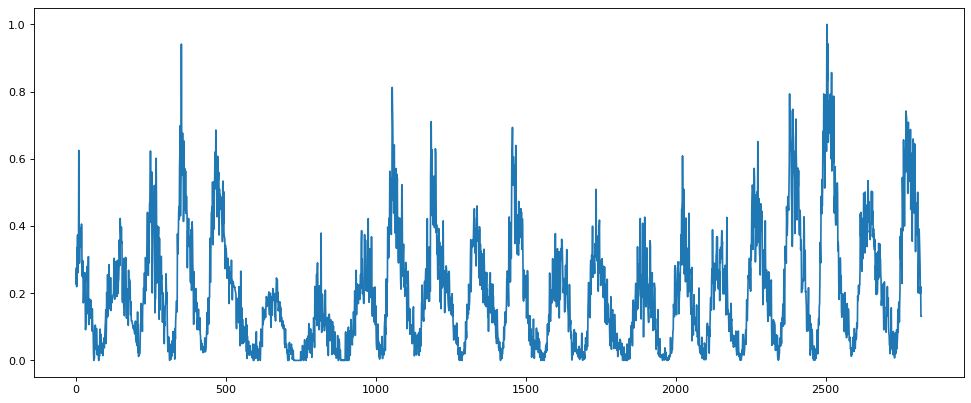

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def read_data(url):
    df = pd.read_csv(url, usecols=['Sunspots'])
    data = df.values
    scaler = MinMaxScaler(feature_range=(0, 1))     ## normalization in range [0, 1]
    data = scaler.fit_transform(data).flatten()
    return data

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
data = read_data(sunspots_url)

#### Plot graph
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(range(len(data)), data)
print(sunspots_url)

# Generate dataset and sequences with time steps

In [ ]:

#Splitting data into train and test based on split ratio
def get_train_test(split_percent, data):
    n = len(data)
    split = int(n * split_percent)
    train_data = data[:split]
    test_data = data[split:]
    return train_data, test_data

split_percent = 0.8     ## 80% of data for train data and 20% of data for test
train_data, test_data = get_train_test(split_percent, data)

## generate sequence input length with a time step
def gen_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)

    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

time_steps = 12     ## number input length
trainX, trainY = gen_XY(train_data, time_steps)
testX, testY = gen_XY(test_data, time_steps)

print(trainX.shape, trainY.shape)
print(data)

(187, 12, 1) (187,)
[0.2285264  0.24665091 0.27580772 ... 0.21985816 0.13120567 0.13159968]


Many to One RNN

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
model = Sequential([
    Input(shape = (time_steps, 1)),         ## input (time step, feature)
    SimpleRNN(10, activation='tanh'),       ## RNN unit
    Dense(1, activation = 'sigmoid')        ## output layer
    ])

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=10, batch_size=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0582
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0057
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044
Epoch 9/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051
Epoch 10/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038


In [ ]:
from sklearn.metrics import mean_squared_error

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_rmse = mean_squared_error(trainY, train_predict)
test_rmse = mean_squared_error(testY, test_predict)
print('Train RMSE: %.3f RMSE' % (train_rmse))
print('Test RMSE: %.3f RMSE' % (test_rmse))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train RMSE: 0.005 RMSE
Test RMSE: 0.011 RMSE


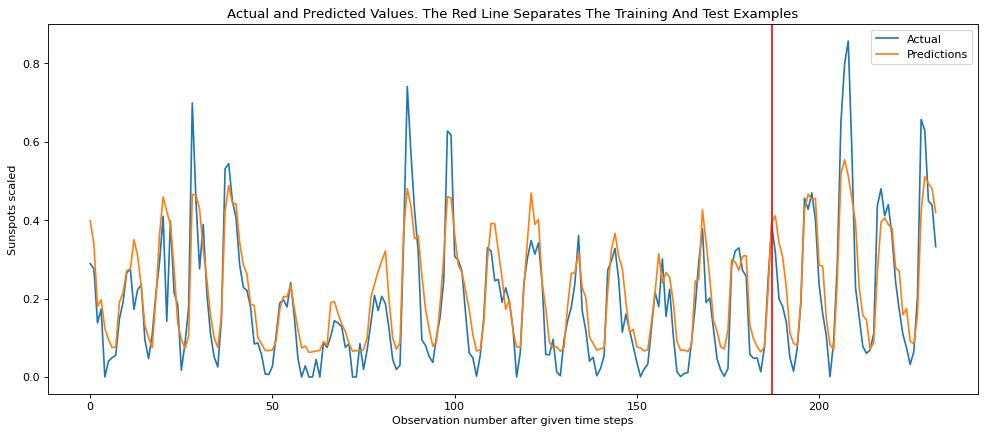

In [ ]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

plot_result(trainY, testY, train_predict, test_predict)

In [ ]:
#Generate input seuqences and output sequences
def gen_XY(dat, input_length, output_length):
    X, Y = [], []
    for i in range(len(dat) - input_length - output_length + 1):
        X.append(dat[i:i+input_length])
        Y.append(dat[i+input_length:i+input_length+output_length])

    X = np.array(X)
    Y = np.array(Y)
    X = np.reshape(X, (X.shape[0], input_length, 1))  #  [samples, time steps, features]
    Y = np.reshape(Y, (Y.shape[0], output_length, 1)) #  [samples, output steps, features]

    return X, Y

input_length = 12  # Length of input sequences
output_length = 5  # Length of output sequences

trainX, trainY = gen_XY(train_data, input_length, output_length)
testX, testY = gen_XY(test_data, input_length, output_length)

print(trainX.shape, trainY.shape)

(2240, 12, 1) (2240, 5, 1)


Sequence-to-Sequence RNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, TimeDistributed, RepeatVector

model = Sequential([
    Input(shape=(input_length, 1)),                  # (time step, feature)
    SimpleRNN(10, activation='tanh'),                # Encoder layer
    RepeatVector(output_length),                     # Repeat vector for generating the output sequence length
    SimpleRNN(10, activation='tanh', return_sequences=True),  ## Decoder layer
    TimeDistributed(Dense(1, activation='sigmoid'))  # TimeDistributed allows to apply a Dense layer to each time step
])

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=10, batch_size=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 10)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 5, 10)               │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 5, 1)                │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 341 (1.33 KB)

 Trainable params: 341 (1.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0160
Epoch 2/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0057
Epoch 3/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0056
Epoch 4/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0055
Epoch 5/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0053
Epoch 6/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0052
Epoch 7/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0052
Epoch 8/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0050
Epoch 9/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0051
Epoch 10/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0050


In [ ]:
xxx = testX[0].reshape(1, 12,1)
yy = model.predict(xxx)

print('actual output', testY[0])
print('predict output', yy.reshape(1, output_length))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
actual output [[0.38770686]
 [0.46966115]
 [0.34081954]
 [0.39795114]
 [0.50197006]]
predict output [[0.40329334 0.37643138 0.36584088 0.3646425  0.36538357]]


In [ ]:
from sklearn.metrics import mean_squared_error

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Reshape to (samples, time steps)
train_predict = train_predict.reshape(train_predict.shape[0], train_predict.shape[1])
trainY = trainY.reshape(trainY.shape[0], trainY.shape[1])

test_predict = test_predict.reshape(test_predict.shape[0], test_predict.shape[1])
testY = testY.reshape(testY.shape[0], testY.shape[1])

# Calculate RMSE
train_rmse = mean_squared_error(trainY, train_predict)
test_rmse = mean_squared_error(testY, test_predict)
print('Train RMSE: %.3f RMSE' % (train_rmse))
print('Test RMSE: %.3f RMSE' % (test_rmse))

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 0.005 RMSE
Test RMSE: 0.009 RMSE


## Stock Price Prediction using RNN

In [ ]:
!pip install yfinance

In [1]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

u= yf.Ticker('PTT.BK')
stock_data = u.history(period="max", actions=False)
stock_data

,Open,High,Low,Close,Volume
Date,,,,,
2001-12-06 00:00:00+07:00,1.405063,1.414307,1.312625,1.321869,1736808000
2001-12-07 00:00:00+07:00,1.340356,1.340356,1.312625,1.312625,412533000
2001-12-10 00:00:00+07:00,1.312625,1.312625,1.312625,1.312625,0
2001-12-11 00:00:00+07:00,1.312624,1.312624,1.257161,1.257161,409158000
2001-12-12 00:00:00+07:00,1.266406,1.303381,1.257162,1.294137,307291000
...,...,...,...,...,...
2024-10-07 00:00:00+07:00,34.000000,34.000000,33.750000,34.000000,15970700
2024-10-08 00:00:00+07:00,34.000000,34.000000,33.750000,33.750000,14942600
2024-10-09 00:00:00+07:00,33.750000,34.000000,33.500000,33.500000,15564000


<Axes: xlabel='Date'>

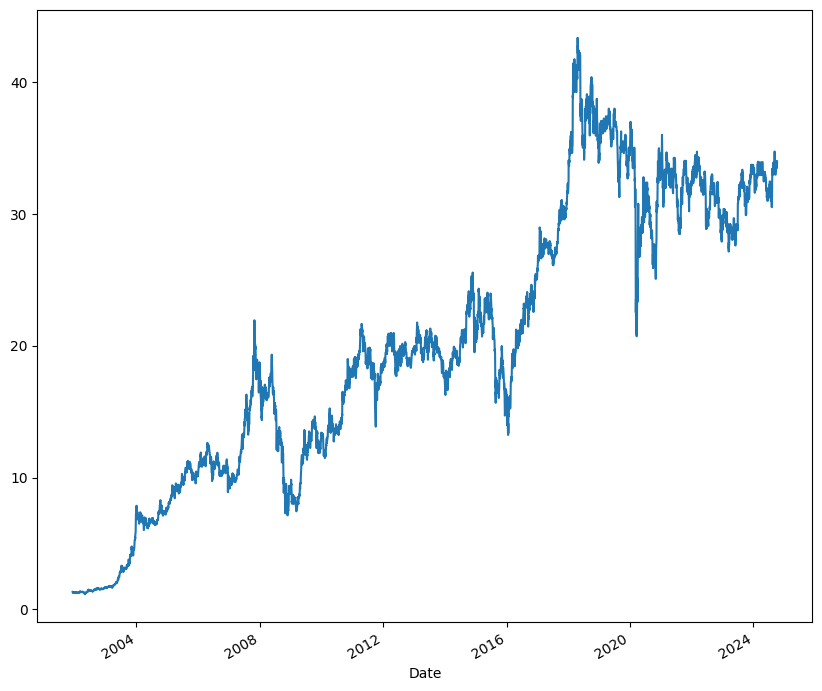

In [ ]:
stock_data['Close'].plot(figsize=(10, 9))

1. จากข้อมูลราคาปิดของหุ้น จงสร้างโมเดล RNN ที่ทำนายราคาปิดของหุ้นในวันถัดไป โดยใช้ข้อมูลย้อนหลัง 7 วัน โดยแบ่งชุดข้อมูลราคาปิดออกเป็น 80% สำหรับฝึก และ 20% สำหรับทดสอบ ตามลำดับ


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
x_data = stock_data['Close'].values

print(x_data)
def get_train_test(split_percent, data):
    n = len(data)
    split = int(n * split_percent)
    train_data = data[:split]
    test_data = data[split:]
    return train_data, test_data
split_percent = 0.8     ## 80% of data for train data and 20% of data for test
train_data, test_data = get_train_test(split_percent, x_data)
print(len(train_data))

def gen_seq(data,timesteps):
  x, y = [], []
  for i in range(len(data)-timesteps):
    x.append(data[i:i+timesteps])
    y.append(data[i+timesteps])
  return np.array(x), np.array(y)
time_steps = 7     ## number input length
trainX, trainY = gen_seq(train_data, time_steps)
testX, testY = gen_seq(test_data, time_steps)

scaler = MinMaxScaler(feature_range=(0,1))
x_train_scar = scaler.fit_transform(trainX.reshape(-1,1))
trainX = x_train_scar.reshape(trainX.shape[0],trainX.shape[1],1)
print(x_train_scar)

x_test_scar = scaler.transform(testX.reshape(-1,1))
testX = x_test_scar.reshape(testX.shape[0],testX.shape[1],1)
# print(trainX.shape, trainY.shape)
# print(trainX)


[ 1.32186854  1.31262457  1.31262457 ... 33.5        33.5
 34.        ]
4516
[[0.00398635]
 [0.00376747]
 [0.00376747]
 ...
 [0.7794564 ]
 [0.77018313]
 [0.77481985]]


In [3]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
model = Sequential([
    Input(shape = (time_steps, 1)),         ## input (time step, feature)
    SimpleRNN(10, activation='tanh'),       ## RNN unit
    Dense(1, activation = 'linear')        ## output layer
    ])

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(trainX, trainY, epochs=10, batch_size=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 166.9163
Epoch 2/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 13.9606
Epoch 3/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1.4268
Epoch 4/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.8719
Epoch 5/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.8453
Epoch 6/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.7648
Epoch 7/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6752
Epoch 8/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.6139
Epoch 9/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.4992
Epoch 10/10
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.4639


ทดสอบความแม่นยำในการทำนายโดยใช้ Mean Squared Error (MSE) พร้อม พล๊อตกราฟเปรียบเทียบราคาปิดจริง (actual close price) และ ราคาปิดที่ถูกทำนาย (predicted close price)

In [4]:
xxx = testX[0].reshape(1, 7,1)
yy = model.predict(xxx)

print('actual output', testY[0])
print('predict output', yy.reshape(1, 1))

from sklearn.metrics import mean_squared_error

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_rmse = mean_squared_error(trainY, train_predict)
test_rmse = mean_squared_error(testY, test_predict)
print('Train RMSE: %.3f RMSE' % (train_rmse))
print('Test RMSE: %.3f RMSE' % (test_rmse))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
actual output 33.28791809082031
predict output [[34.33852]]
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 0.273 RMSE
Test RMSE: 0.615 RMSE


3. จงปรับปรุงให้โมเดล RNN รับอินพุตเป็นราคาปิด (closed price) และปริมาณซื้อขาย (volume) ย้อนหลัง 7 วัน เพื่อทำนายราคาปิดในวันถัดไป พร้อมทดสอบความแม่นยำ

In [5]:
x_data = stock_data[['Close','Volume']].values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
print(x_data)

def get_train_test(split_percent, data):
    n = len(data)
    split = int(n * split_percent)
    train_data = data[:split]
    test_data = data[split:]
    return train_data, test_data
split_percent = 0.8     ## 80% of data for train data and 20% of data for test
train_data, test_data = get_train_test(split_percent, x_data)
print(len(train_data))

def gen_seq(data,timesteps):
  x, y = [], []
  for i in range(len(data)-timesteps):
    x.append(data[i:i+timesteps])
    y.append(data[i+timesteps][0])
  return np.array(x), np.array(y)
time_steps = 7     ## number input length
trainX, trainY = gen_seq(train_data, time_steps)
testX, testY = gen_seq(test_data, time_steps)

scaler = MinMaxScaler(feature_range=(0,1))
x_train_scar = scaler.fit_transform(trainX.reshape(-1,2))
trainX = x_train_scar.reshape(trainX.shape[0],trainX.shape[1],2)
print(x_train_scar)
x_test_scar = scaler.transform(testX.reshape(-1,2))
testX = x_test_scar.reshape(testX.shape[0],testX.shape[1],2)
print(trainX.shape, trainY.shape)
print(trainY)




[[1.32186854e+00 1.73680800e+09]
 [1.31262457e+00 4.12533000e+08]
 [1.31262457e+00 0.00000000e+00]
 ...
 [3.35000000e+01 1.55640000e+07]
 [3.35000000e+01 7.27060000e+06]
 [3.40000000e+01 6.09099730e+07]]
4516
[[0.00398635 1.        ]
 [0.00376747 0.23752366]
 [0.00376747 0.        ]
 ...
 [0.7794564  0.02238992]
 [0.77018313 0.02732524]
 [0.77481985 0.02337432]]
(4509, 7, 2) (4509,)
[ 1.27564907  1.27564907  1.26640594 ... 33.67953873 33.87535477
 33.67953873]


In [6]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense , Dropout
from tensorflow.keras.models import Sequential
model = Sequential([
    Input(shape = (time_steps, 2)),         ## input (time step, feature)
    SimpleRNN(50, activation='tanh'),      ## RNN unit
    # Dropout(0.2),
    Dense(1, activation = 'linear')        ## output layer
    ])

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
hist3 = model.fit(trainX, trainY, epochs=50, batch_size=16)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           2,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 202.3214
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 91.8665
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.4719
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.5030
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4689
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5310
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0765
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8201
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8110
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8309
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6787
Epoch 12/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7987
Epoch 13/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7498
Epoch 14/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6802
Epoch 15/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

In [7]:
xxx = testX[0].reshape(1, 7,2)
yy = model.predict(xxx)

print('actual output', testY[0])
print('predict output', yy.reshape(1, 1))

from sklearn.metrics import mean_squared_error

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_rmse = mean_squared_error(trainY, train_predict)
test_rmse = mean_squared_error(testY, test_predict)
print('Train RMSE: %.3f RMSE' % (train_rmse))
print('Test RMSE: %.3f RMSE' % (test_rmse))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
actual output 33.28791809082031
predict output [[34.51692]]
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 0.625 RMSE
Test RMSE: 1.473 RMSE


4. จากโมเดลที่ปรับปรุงในข้อที่ 3 พล๊อตกราฟเปรียบเทียบราคาปิดจริง (actual close price) และ ราคาปิดที่ถูกทำนาย (predicted close price)

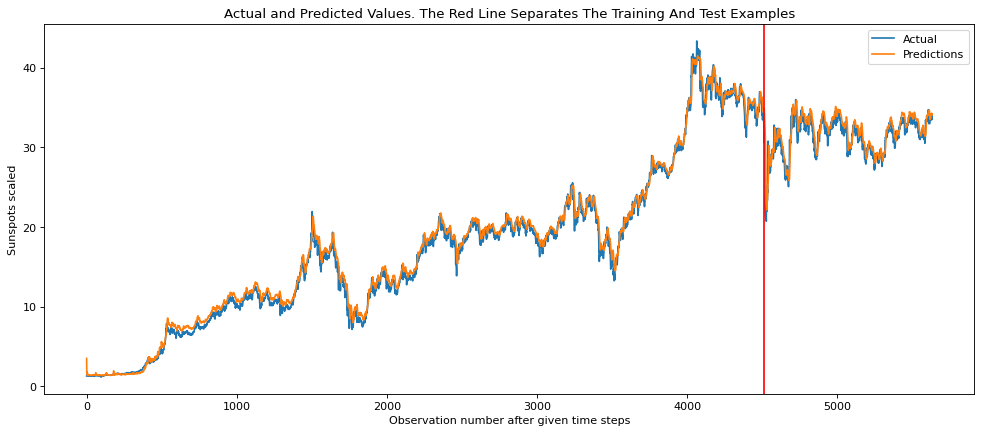

In [8]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

plot_result(trainY, testY, train_predict, test_predict)

5. จงใช้โมเดล GRU รับอินพุตเป็นราคาปิด (closed price) และปริมาณซื้อขาย (volume) ย้อนหลัง 30 วัน และทำนายราคาปิด 5 วันถัดไป แบ่งชุดข้อมูลออกเป็น 80% และ 20% สำหรับฝึกและทดสอบ ตามลำดับ พร้อมทดสอบความแม่นยำบนชุดข้อมูลทดสอบโดยใช้ mean square error

In [9]:
x_data = stock_data[['Close','Volume']].values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
print(x_data)

def get_train_test(split_percent, data):
    n = len(data)
    split = int(n * split_percent)
    train_data = data[:split]
    test_data = data[split:]
    return train_data, test_data
split_percent = 0.8     ## 80% of data for train data and 20% of data for test
train_data, test_data = get_train_test(split_percent, x_data)
print(len(train_data))

def gen_seq(data,timesteps,outsteps):
  x, y = [], []
  # for i in range(len(data)-timesteps):
  for i in range(len(data) - timesteps - outsteps + 1):
    x.append(data[i:i+timesteps])
    # y.append(data[i:i+outsteps][0])
    y.append([data[i + timesteps + j][0] for j in range(outsteps)])
  return np.array(x), np.array(y)
time_steps = 30     ## number input length
out_time = 7
trainX, trainY = gen_seq(train_data, time_steps,out_time)
testX, testY = gen_seq(test_data, time_steps,out_time)

scaler = MinMaxScaler(feature_range=(0,1))
x_train_scar = scaler.fit_transform(trainX.reshape(-1,2))
trainX = x_train_scar.reshape(trainX.shape[0],trainX.shape[1],2)
print(x_train_scar)
x_test_scar = scaler.transform(testX.reshape(-1,2))
testX = x_test_scar.reshape(testX.shape[0],testX.shape[1],2)
print(trainX.shape, trainY.shape)
print(trainY)


[[1.32186854e+00 1.73680800e+09]
 [1.31262457e+00 4.12533000e+08]
 [1.31262457e+00 0.00000000e+00]
 ...
 [3.35000000e+01 1.55640000e+07]
 [3.35000000e+01 7.27060000e+06]
 [3.40000000e+01 6.09099730e+07]]
4516
[[0.00398635 1.        ]
 [0.00376747 0.23752366]
 [0.00376747 0.        ]
 ...
 [0.7794564  0.00908909]
 [0.77481985 0.01955962]
 [0.76554676 0.02381248]]
(4480, 30, 2) (4480, 7)
[[ 1.28489339  1.27564907  1.27564907 ...  1.27564907  1.27564907
   1.26640594]
 [ 1.27564907  1.27564907  1.27564907 ...  1.27564907  1.26640594
   1.26640594]
 [ 1.27564907  1.27564907  1.27564907 ...  1.26640594  1.26640594
   1.26640594]
 ...
 [33.87535477 33.48373795 33.67953873 ... 34.2669754  34.07116318
  33.67953873]
 [33.48373795 33.67953873 33.87535477 ... 34.07116318 33.67953873
  33.87535477]
 [33.67953873 33.87535477 34.2669754  ... 33.67953873 33.87535477
  33.67953873]]


In [10]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
model = Sequential([
    Input(shape = (time_steps, 2)),         ## input (time step, feature)
    SimpleRNN(30, activation='tanh'),       ## RNN unit
    Dense(7, activation = 'linear')        ## output layer
    ])

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
hist3 = model.fit(trainX, trainY, epochs=50, batch_size=16)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 30)                  │             990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             217 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,207 (4.71 KB)

 Trainable params: 1,207 (4.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 310.7311
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 144.0948
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 104.7839
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 101.3915
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 94.1039
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 96.5312
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 95.3444
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 92.1575
Epoch 9/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 82.2649
Epoch 10/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 42.5710
Epoch 11/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 18.5229
Epoch 12/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.3166
Epoch 13/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.1193
Epoch 14/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.2695
Epoch 15/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 1

In [11]:
xxx = testX[0].reshape(1, 30,2)
yy = model.predict(xxx)

print('actual output', testY[0])
print('predict output', yy)

from sklearn.metrics import mean_squared_error

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_rmse = mean_squared_error(trainY, train_predict)
test_rmse = mean_squared_error(testY, test_predict)
print('Train RMSE: %.3f RMSE' % (train_rmse))
print('Test RMSE: %.3f RMSE' % (test_rmse))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
actual output [24.14923859 23.34426308 24.75296974 24.35048294 27.16789627 28.57659721
 30.79027367]
predict output [[24.785019 24.873905 24.816212 24.773485 24.871857 24.802654 24.820393]]
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train RMSE: 0.500 RMSE
Test RMSE: 1.097 RMSE
